# Librerías

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2

# Funciones y Clases Generales

In [52]:
class ROISelector:
    '''
    Clase para seleccionar un ROI de una imagen.
    '''
    def __init__(self, image):
        self.image = image.copy()
        self.clone = self.image.copy()
        self.x_init, self.y_init = -1, -1
        self.roi = None

    def select_roi(self, event, x, y, flags, param):
        '''
        Método para seleccionar un ROI de una imagen.

        Parámetros:
            event (cv2 event): evento de OpenCV
            x (int): coordenada x del mouse
            y (int): coordenada y del mouse
            flags (int): flags de OpenCV
            param (any): parámetro adicional
        '''
        if event == cv2.EVENT_LBUTTONDOWN:
            self.x_init, self.y_init = x, y
        elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
            self.image = self.clone.copy()
            cv2.rectangle(self.image, (self.x_init, self.y_init), (x, y), (255, 255, 255), 2)
        elif event == cv2.EVENT_LBUTTONUP:
            self.roi = self.clone[min(self.y_init, y):max(self.y_init, y),
                                 min(self.x_init, x):max(self.x_init, x)]
            cv2.rectangle(self.image, (self.x_init, self.y_init), (x, y), (255, 255, 255), 2)
            cv2.imshow("ROI", self.roi)

    def run(self):
        '''
        Método para ejecutar la selección del ROI.

        Retorno:
            np.array: ROI seleccionado
        '''
        cv2.namedWindow("Image")
        cv2.setMouseCallback("Image", self.select_roi)

        while True:
            cv2.imshow("Image", self.image)
            key = cv2.waitKey(1) & 0xFF

            if key == 27:
                print("Proceso terminado por el usuario.")
                break
            elif self.roi is not None and (key == 13 or key == 10):
                print("ROI seleccionada, devolviendo el array.")
                cv2.destroyAllWindows()
                return self.roi

        cv2.destroyAllWindows()
        return None

In [53]:
def convolution(image, kernel):
    '''
    Ejecuta la operación de convolución a la imagen con el kernel dado.

    Parámetros:
        image (np.array): imagen de entrada
        kernel (np.array): kernel de convolución

    Retorno:
        np.array: imagen resultante de la convolución
    '''
    # Obtener las dimensiones de la imagen y el kernel
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Calcular el padding para cada dimensión (alto y ancho)
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    # Crear la imagen con padding
    padded_image = np.zeros((image_h + kernel_h - 1, image_w + kernel_w - 1))
    padded_image[pad_h:pad_h + image_h, pad_w:pad_w + image_w] = image

    # Proceso de convolución
    output = np.zeros_like(image)

    for y in range(image_h):
        for x in range(image_w):
            output[y, x] = np.sum(kernel * padded_image[y:y+kernel_h, x:x+kernel_w])

    return output

def filter_for_image(image, kernel):
    '''
    Crea un filtro para una imagen con un kernel dado.

    Parámetros:
        image (np.array): imagen de entrada
        kernel (np.array): kernel de convolución

    Retorno:
        np.array: filtro para la imagen
    '''
    # Creación de filtro para imagen
    filtro_detector = convolution(image, kernel)

    # Eliminamos filas y columnas que tienen solo 0's
    row_not_zeros = np.any(filtro_detector != 0, axis=1)
    col_not_zeros = np.any(filtro_detector != 0, axis=0)
    filtro_detector = filtro_detector[row_not_zeros][:, col_not_zeros]

    return filtro_detector

def show_image(images, titles):
    '''
    Muestra una o un conjunto de imágenes en un solo plot, destacan las dimensiones de cada imagen.

    Parámetros
        images (np.array, list): Imagen o lista de imágenes a mostrar.
    '''
    if not isinstance(images, list):
        plot_images = [images]
        titles = [titles]

    fig, axs = plt.subplots(1, len(images), figsize = (20, 10))

    # Si solo hay una imagen, axs no es una lista, así que lo convertimos en lista para simplificar el bucle
    if len(images) == 1:
        axs = [axs]

    for i, image in enumerate(images):
        axs[i].imshow(image, cmap = 'gray')
        axs[i].set_title(titles[i])

# Detección de letra `L`

In [54]:
L_letter = np.zeros((10, 10))
L_letter[3:6, 3] = 1  # Parte vertical de la "L"
L_letter[5, 3:5] = 1  # Parte horizontal de la "L"

kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

In [55]:
filter_for_L = filter_for_image(L_letter, kernel)
L_founded = convolution(L_letter, filter_for_L)

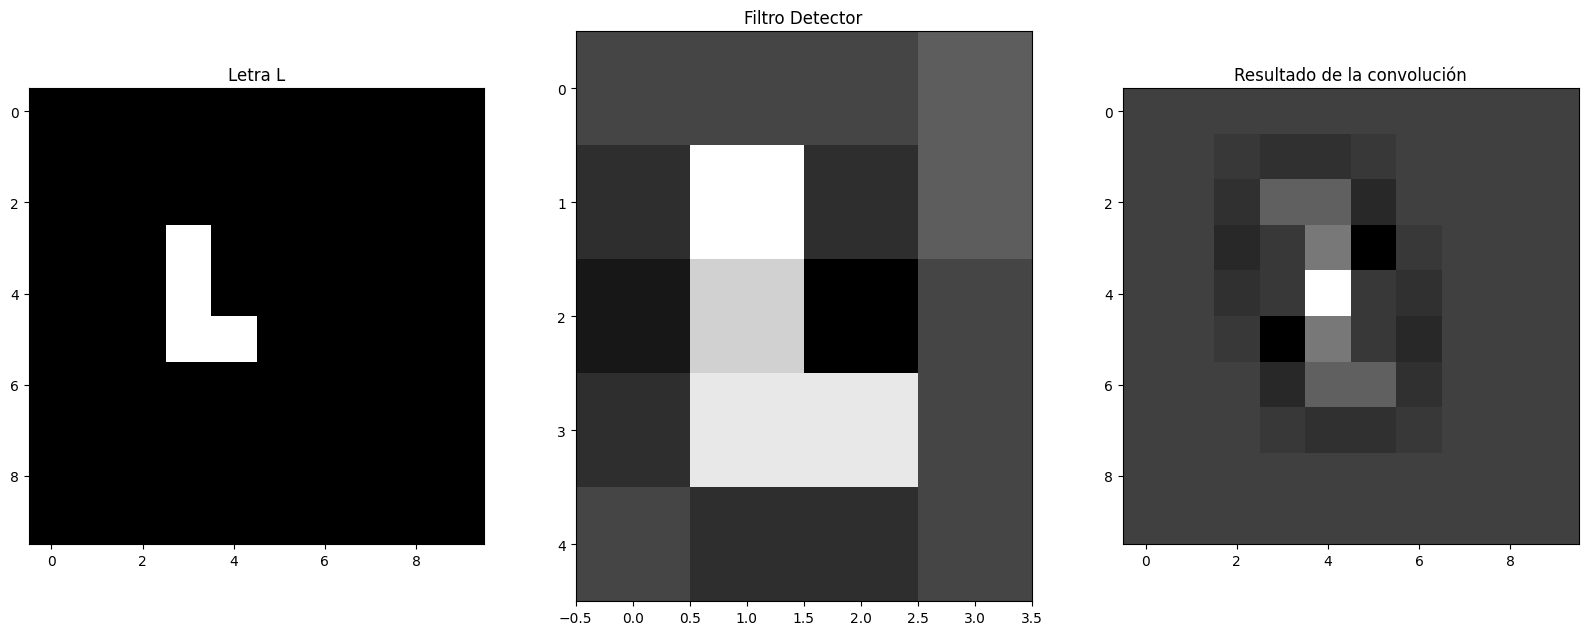

In [56]:
show_image([L_letter, filter_for_L, L_founded], ['Letra L', 'Filtro Detector', 'Resultado de la convolución'])

In [57]:
# Valores del filtro
filter_for_L

array([[-1., -1., -1.,  0.],
       [-2.,  7., -2.,  0.],
       [-3.,  5., -4., -1.],
       [-2.,  6.,  6., -1.],
       [-1., -2., -2., -1.]])

In [58]:
# Valores de la convolución
L_founded

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -2., -2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  4.,  4., -3.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -3., -1.,  7., -8., -1.,  0.,  0.,  0.],
       [ 0.,  0., -2., -1., 24., -1., -2.,  0.,  0.,  0.],
       [ 0.,  0., -1., -8.,  7., -1., -3.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -3.,  4.,  4., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1., -2., -2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

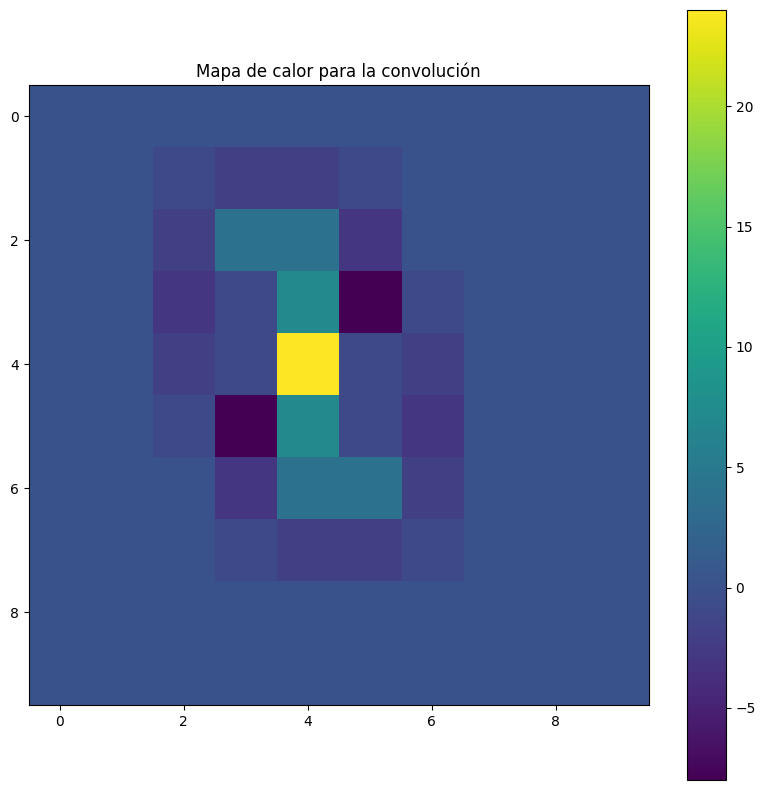

In [59]:
# Mapa de calor para la convolución
plt.figure(figsize=(10, 10))
plt.imshow(L_founded, cmap='viridis')
plt.colorbar()
plt.title('Mapa de calor para la convolución')
plt.show()

# Detección de Patrones Complejos

In [60]:
# Carga de imagen
six_diamond = cv2.imread('Imagenes/seis.jpg')
six_diamond_gray = cv2.cvtColor(six_diamond, cv2.COLOR_BGR2GRAY)

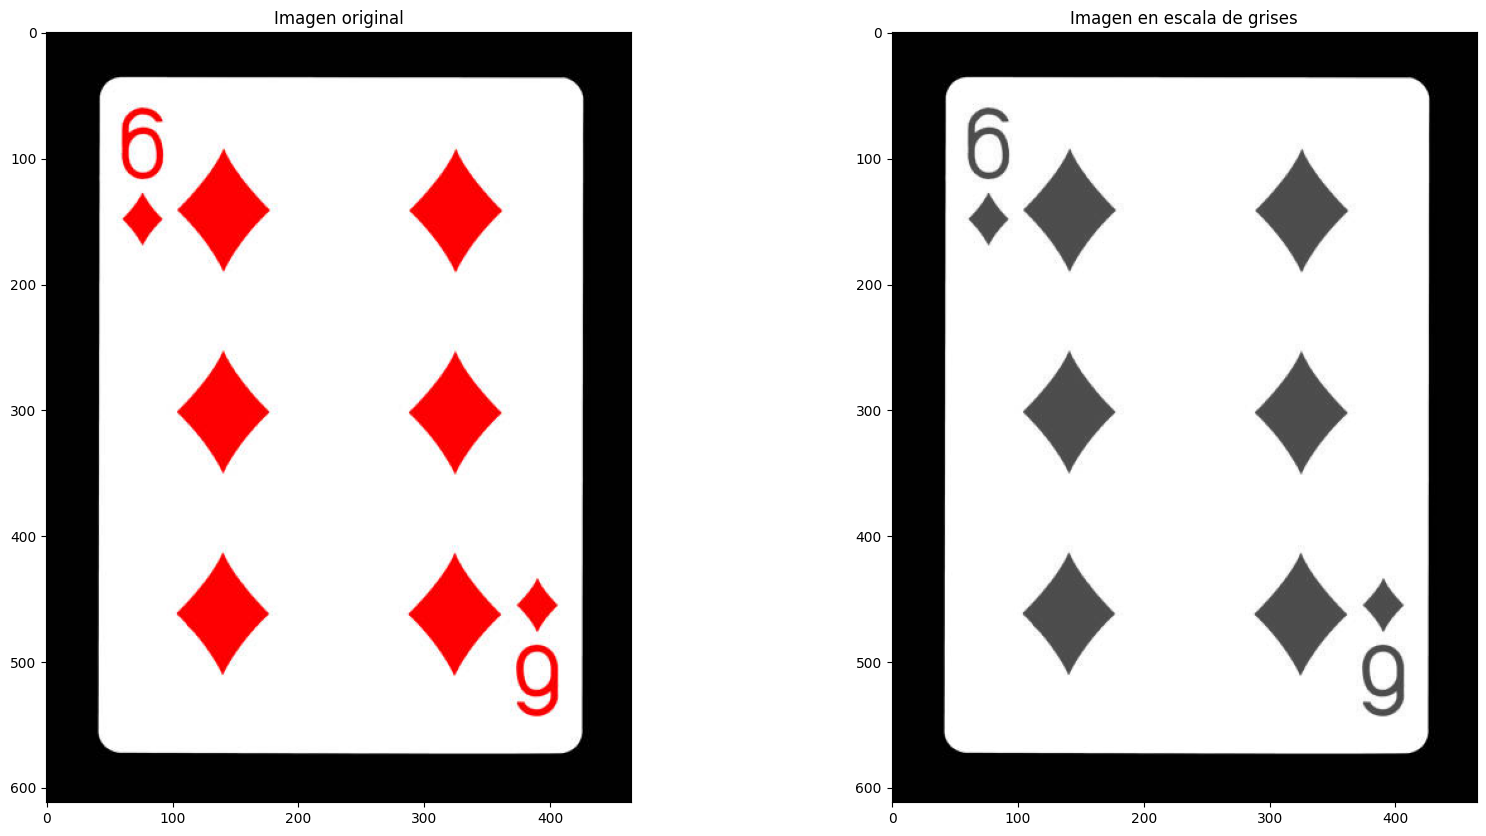

In [61]:
show_image([cv2.cvtColor(six_diamond, cv2.COLOR_BGR2RGB), six_diamond_gray], ['Imagen original', 'Imagen en escala de grises'])

## Lectura de imágenes


In [62]:
# Binarización de imágenes
seis_bin = cv2.threshold(six_diamond_gray, 128 ,255, cv2.THRESH_BINARY)[1]

# Binarización invertida
seis_bin_inv = cv2.bitwise_not(seis_bin)

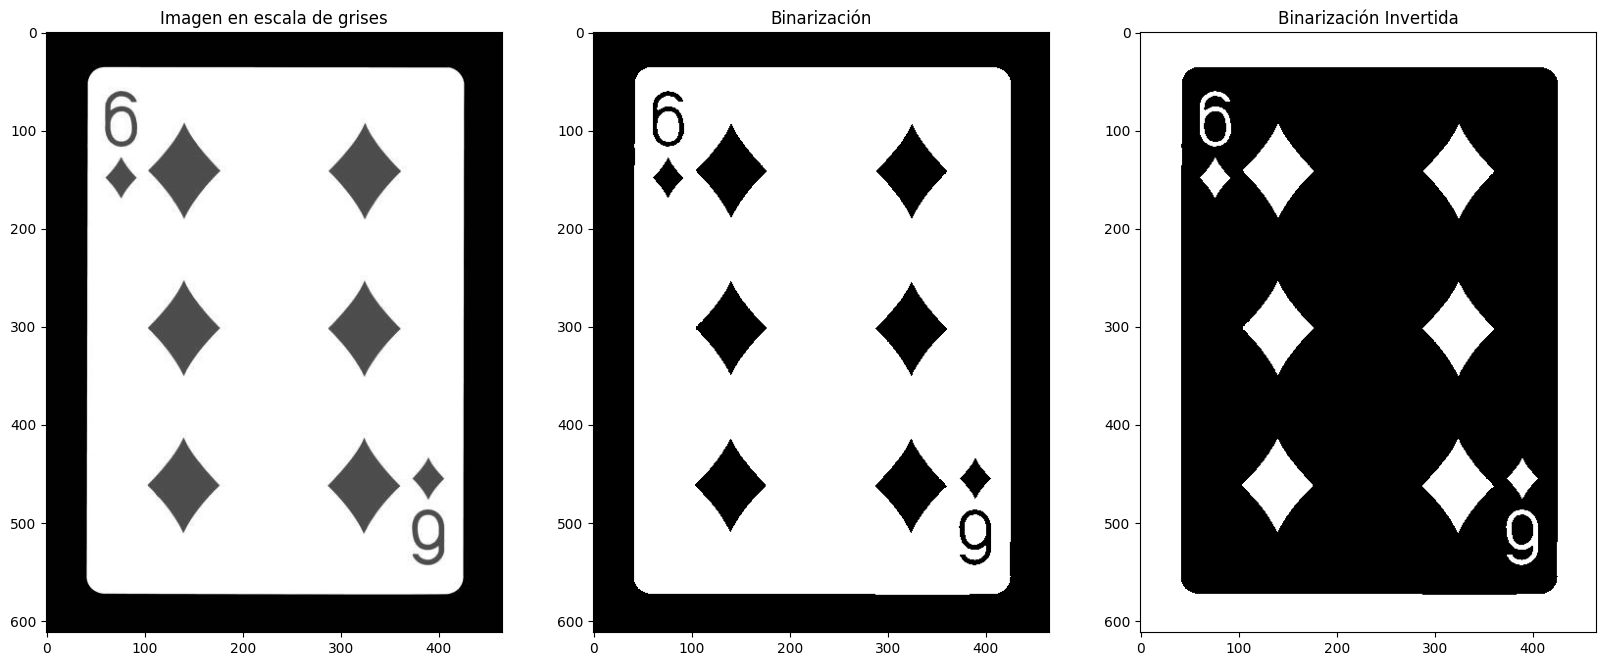

In [63]:
show_image([six_diamond_gray, seis_bin, seis_bin_inv], ['Imagen en escala de grises', 'Binarización', 'Binarización Invertida'])

## Definición de Patrón

In [46]:
# Haremos las detecciones de los patrones que queremos buscar en las imágenes
selector_diamante = ROISelector(seis_bin_inv)
roi_diamante = selector_diamante.run()

ROI seleccionada, devolviendo el array.


## Creación del Filtro Detector

In [47]:
# Usamos la funció nde convolución para obtener el filtro
filter_for_diamond = filter_for_image(roi_diamante, kernel)

## Detección del Patrón

In [48]:
# Usamos la misma función de convolución para detectar el patrón en la imagen usando el filtro recién creado
initial_detection_diamond = convolution(seis_bin, filter_for_diamond)

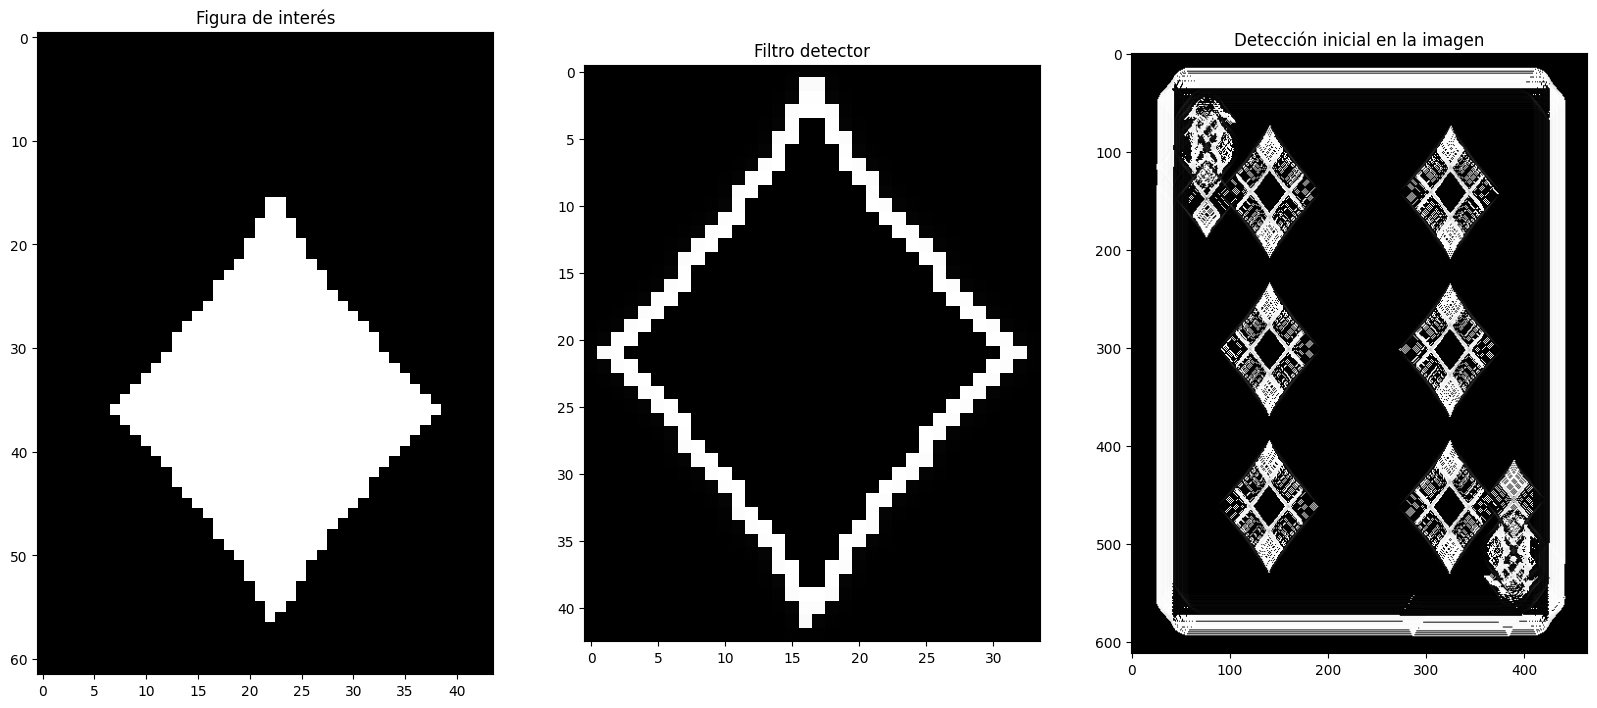

In [49]:
show_image([roi_diamante, filter_for_diamond, initial_detection_diamond], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

## Determinación del Umbral

Convierta la matriz resultante del punto anterior a un vector fila, y muestre los resultados en un gráfico. Esto le servirá para decidir un umbral de detección, por ejemplo, para el resultado mostrado en la Figura 2, un umbral adecuado sería aproximadamente 300 (poco más de un 60 % del estímulo máximo).

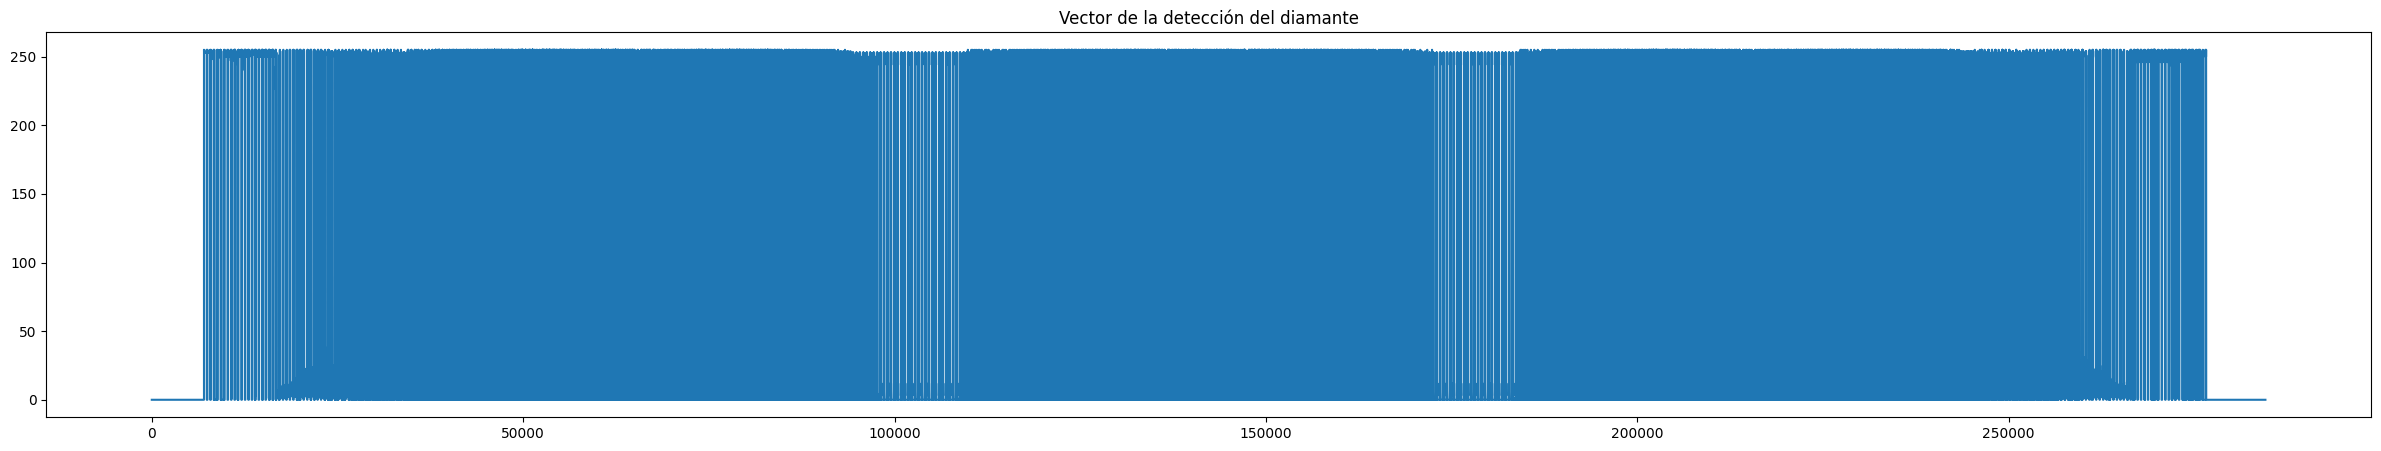

In [67]:
# Convertir matriz resultante a vector fila
diamond = initial_detection_diamond.flatten()

# Mostrar el vector en un gráfico
plt.figure(figsize=(30, 5))
plt.plot(diamond)
plt.title('Vector de la detección del diamante')
plt.show()

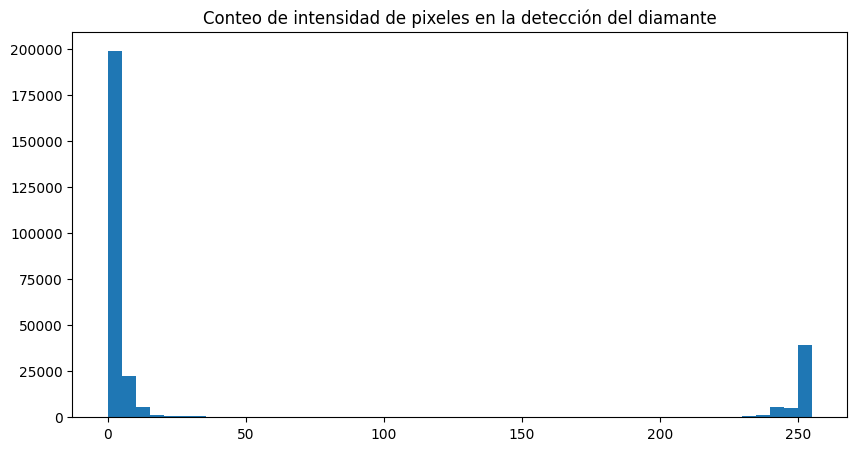

In [71]:
# Conteo de detecciones según la intensidad de pixel y graficar
plt.figure(figsize=(10, 5))
plt.hist(diamond, bins=50)
plt.title('Conteo de intensidad de pixeles en la detección del diamante')
plt.show()

## Supresión de no Máximos o Non-Max Supression (NMS)

Debe tener en consideración que puede existir más de un punto, asociado a la detección de un mismo objeto, que supere el umbral definido. En estos casos, la idea es conservar solo el punto de máxima activación. Para esto, recupere las posiciones (x, y) de los valores que superan el umbral e implemente y ejecute un algoritmo para evitar múltiples detecciones de un mismo objeto.

## Visualización de la detección